## Deduplication of modelling dataset

We are using a deduplication by DOI.

In [1]:
# Libraries used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [2]:
# Read initial data, merging csv files from each database
pattern_wos = sorted(glob.glob("./bulk_data/model_wos_[0-9]*.csv"))
dfModellingWOSList = [pd.read_csv(file_name, sep='\t') for file_name in pattern_wos]
dfModellingWOSOriginal = pd.concat(dfModellingWOSList, ignore_index=True)

pattern_scopus = sorted(glob.glob("./bulk_data/model_scopus_[0-9]*.csv"))
dfModellingScopusList = [pd.read_csv(file_name, sep=',') for file_name in pattern_scopus]
dfModellingScopusOriginal = pd.concat(dfModellingScopusList, ignore_index=True)

## Fill source for WoS papers
dfModellingWOSOriginal['source'] = 'Web of Science'

## Remove papers without DOI
dfModellingScopus = dfModellingScopusOriginal[dfModellingScopusOriginal['DOI'].notnull()]
dfModellingWOS = dfModellingWOSOriginal[dfModellingWOSOriginal['DI'].notnull()]

## Converting DOI to lowercase
dfModellingScopus.loc[:, 'DOI'] = dfModellingScopus['DOI'].str.lower()
dfModellingWOS.loc[:, 'DI'] = dfModellingWOS['DI'].str.lower()

# Print size of dataframes and removed papers
removed_scopus = len(dfModellingScopusOriginal) - len(dfModellingScopus)
removed_WOS = len(dfModellingWOSOriginal) - len(dfModellingWOS)
print('Scopus len:', len(dfModellingScopus), ', removed', removed_scopus, 'without DOI')
print('WoS len:', len(dfModellingWOS), 'removed', removed_WOS, 'without DOI')

# Print columns name
print('Scopus columns:', dfModellingScopus.columns.values)
print('WoS columns:', dfModellingWOS.columns.values)

Scopus len: 3483 , removed 206 without DOI
WoS len: 4309 removed 321 without DOI
Scopus columns: ['Authors' 'Author(s) ID' 'Title' 'Year' 'Source title' 'Volume' 'Issue'
 'Art. No.' 'Page start' 'Page end' 'Page count' 'Cited by' 'DOI' 'Link'
 'Affiliations' 'Authors with affiliations' 'Abstract' 'Author Keywords'
 'Index Keywords' 'References' 'Correspondence Address' 'Editors'
 'Publisher' 'ISSN' 'ISBN' 'CODEN' 'PubMed ID'
 'Language of Original Document' 'Abbreviated Source Title'
 'Document Type' 'Publication Stage' 'Open Access' 'Source' 'EID']
WoS columns: ['PT' 'AU' 'BA' 'BE' 'GP' 'AF' 'BF' 'CA' 'TI' 'SO' 'SE' 'BS' 'LA' 'DT'
 'CT' 'CY' 'CL' 'SP' 'HO' 'DE' 'ID' 'AB' 'C1' 'C3' 'RP' 'EM' 'RI' 'OI'
 'FU' 'FP' 'FX' 'CR' 'NR' 'TC' 'Z9' 'U1' 'U2' 'PU' 'PI' 'PA' 'SN' 'EI'
 'BN' 'J9' 'JI' 'PD' 'PY' 'VL' 'IS' 'PN' 'SU' 'SI' 'MA' 'BP' 'EP' 'AR'
 'DI' 'DL' 'D2' 'EA' 'PG' 'WC' 'WE' 'SC' 'GA' 'PM' 'OA' 'HC' 'HP' 'DA'
 'UT' 'source']


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [3]:
# Rename columns

columns_scopus = [
    'Title', 'Authors', 'DOI', 'Source title', 'Year', 'Cited by', 
    'Author Keywords', 'Affiliations', 'Abstract', 'References', 'Publisher', 'ISSN', 
    'Language of Original Document', 'Document Type', 'Source'
]

columns_wos = [
    'TI', 'AU', 'DI', 'SO', 'PY', 'Z9', 
    'DE', 'C3', 'AB', 'CR', 'PU', 'SN', 
    'LA', 'DT', 'source'
]

final_columns = [
    'title', 'authors', 'DOI', 'journal_name', 'year', 'number_citation', 
    'author_keywords', 'affiliations', 'abstract', 'references', 'publisher', 'ISSN', 
    'language', 'document_type', 'source'
]

drop_columns = set(dfModellingScopus.columns.values) - set(columns_scopus)
rename_columns = dict(zip(columns_scopus, final_columns))
dfModellingScopus = dfModellingScopus.drop(columns=drop_columns)
dfModellingScopus = dfModellingScopus.rename(columns=rename_columns)

drop_columns = set(dfModellingWOS.columns.values) - set(columns_wos)
rename_columns = dict(zip(columns_wos, final_columns))
dfModellingWOS = dfModellingWOS.drop(columns=drop_columns)
dfModellingWOS = dfModellingWOS.rename(columns=rename_columns)

In [4]:
scopus_without_ISSN = len(dfModellingScopus[dfModellingScopus['ISSN'].isnull()])
print(f'In scopus {scopus_without_ISSN} ({scopus_without_ISSN / len(dfModellingScopus)}) papers are without ISSN')
# In scopus all of them are conference paper
print(f"They have type {dfModellingScopus[dfModellingScopus['ISSN'].isnull()]['document_type'].unique()}")


wos_without_ISSN = len(dfModellingWOS[dfModellingWOS['ISSN'].isnull()])
print(f'In WoS {wos_without_ISSN} ({wos_without_ISSN / len(dfModellingWOS)}) papers are without ISSN')
# in wos they have different origins
print(f"They have type {dfModellingWOS[dfModellingWOS['ISSN'].isnull()]['document_type'].unique()}")

In scopus 271 (0.07780648865920184) papers are without ISSN
They have type ['Conference Paper']
In WoS 443 (0.10280807611974936) papers are without ISSN
They have type ['Article' 'Proceedings Paper' 'Article; Proceedings Paper'
 'Article; Data Paper']


In [5]:
# If the paper is duplicated in the databases complete missing values from Scopus using WoS. 
# Also mark duplicated papers.

for idx, row in dfModellingScopus.iterrows():
    dfModellingWOSDuplicate = dfModellingWOS.loc[dfModellingWOS['DOI']== row.DOI]
    
    if not dfModellingWOSDuplicate.empty:
        dfModellingScopus.loc[idx, 'source'] = 'Scopus;Web of Science'

        if pd.isna(row['year']) and pd.notna(dfModellingWOSDuplicate['year'].values[0]): 
            dfModellingScopus.loc[idx, 'year'] = dfModellingWOSDuplicate['year'].values[0]
        if pd.isna(row['author_keywords']) and pd.notna(dfModellingWOSDuplicate['author_keywords'].values[0]): 
            dfModellingScopus.loc[idx, 'author_keywords'] = dfModellingWOSDuplicate['author_keywords'].values[0]
        if pd.isna(row['number_citation']) and pd.notna(dfModellingWOSDuplicate['number_citation'].values[0]): 
            dfModellingScopus.loc[idx, 'number_citation'] = dfModellingWOSDuplicate['number_citation'].values[0]

# Merge dataframes and remove duplicates by DOI 
dfModelling = pd.concat([dfModellingScopus, dfModellingWOS], ignore_index=True)[final_columns]
dfModelling = dfModelling.drop_duplicates(subset=['DOI'], keep='first')

In [6]:
# Cleaning dataframe before saving

# Add date of export
dfModelling['date_export'] = '2023-01-24'

# Add link from DOI
dfModelling['link'] = 'https://dx.doi.org/' + dfModelling['DOI']

# Clean strings for ISSN and journal_name
dfModelling['ISSN'] = dfModelling['ISSN'].str.replace('[^\w\s]','')
dfModelling['journal_name'] = dfModelling['journal_name'].str.capitalize()

# For now consider only Article, removing proceedings
dfModelling = dfModelling[dfModelling['document_type'] == 'Article']

# Unify journal_name
for name, group in dfModelling[dfModelling['ISSN'].notnull()].groupby('ISSN'):
    different_names = set(group['journal_name'].unique())
    
    if len(different_names) > 1:
        scopus_names = sorted(group[group['source'] != 'Web of Science']['journal_name'].unique())
        for alternative_name in (different_names - {scopus_names[0]}):
            dfModelling.loc[dfModelling['journal_name'] == alternative_name, 'journal_name'] = scopus_names[0]
            #print(f'{alternative_name} renamed to {scopus_names[0]}')
            
# Reset index
dfModelling.reset_index(drop=True, inplace=True)

In [7]:
# Print length of final dataset
print('Final length:', len(dfModelling))

# Save dataset
dfModelling.to_csv('data/modelling.csv', index_label='index')

Final length: 4994


## Computing basic statistics of modelling dataset

In [8]:
sns.set_context(rc = {'patch.linewidth': 0.0})

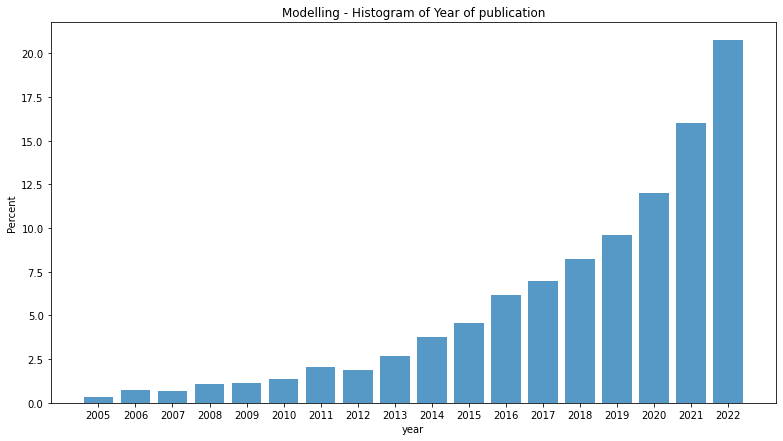

In [9]:
plt.figure(figsize=(13, 7))
sns.histplot(data=dfModelling[dfModelling.year.notnull()], x='year', stat='percent', bins=18, shrink=.8)

plt.xticks(np.arange(2005.5, 2023.5, step=1), np.arange(2005, 2023, step=1)) 
plt.title('Modelling - Histogram of Year of publication')
plt.show()

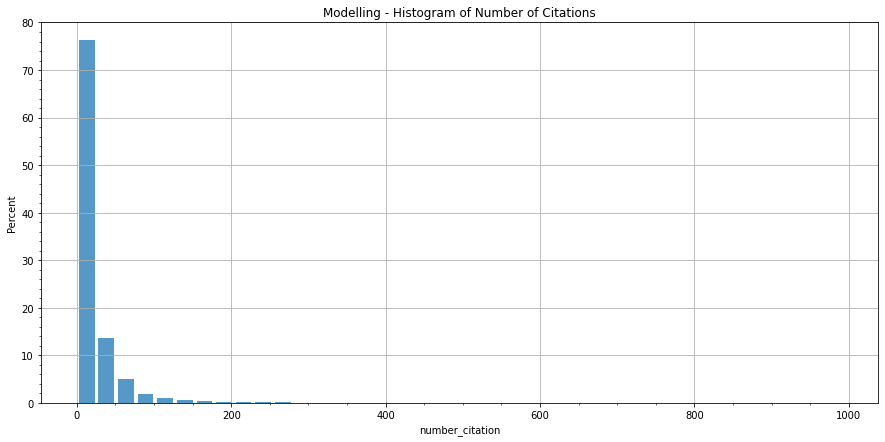

More than  200 citations 40
Removing less than 5 citations:  4113 papers


In [10]:
cut_line = 200

plt.figure(figsize=(15, 7))

sns.histplot(
    data=dfModelling[dfModelling['number_citation'].notnull()], x='number_citation', stat='percent', bins=39, shrink=.8
)

plt.title('Modelling - Histogram of Number of Citations')
plt.minorticks_on()
plt.grid()
plt.show()

print('More than ', cut_line, 'citations', (dfModelling['number_citation'] > cut_line).sum())
print('Removing less than 5 citations: ', len(dfModelling) - 881, 'papers')

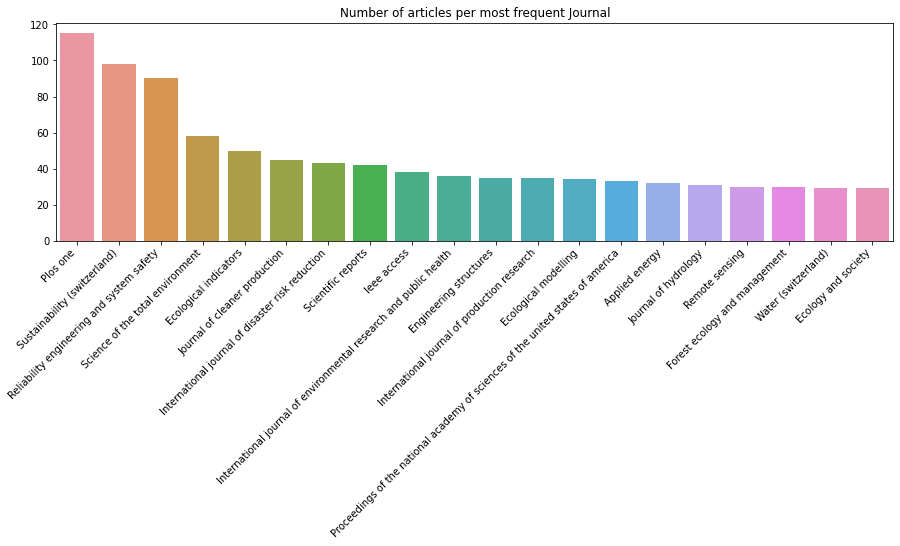

In [11]:
plt.figure(figsize=(15, 4))

dfPlot = dfModelling['journal_name'].value_counts().head(20)

sns.barplot(x=dfPlot.index, y=dfPlot.values)

plt.title('Number of articles per most frequent Journal')
plt.xticks(rotation=45, ha='right')
plt.show()